#                                计算机视觉的应用

## 概述

计算机视觉是当前深度学习研究最广泛、落地最成熟的技术领域，在手机拍照、智能安防、自动驾驶等场景有广泛应用。从2012年AlexNet在ImageNet比赛夺冠以来，深度学习深刻推动了计算机视觉领域的发展，当前最先进的计算机视觉算法几乎都是深度学习相关的。深度神经网络可以逐层提取图像特征，并保持局部不变性，被广泛应用于分类、检测、分割、跟踪、检索、识别、提升、重建等视觉任务中。
本次体验结合图像分类任务，介绍MindSpore如何应用于计算机视觉场景，如何训练模型，得出一个性能较优的模型。


## 图像分类

图像分类是最基础的计算机视觉应用，属于有监督学习类别。给定一张数字图像，判断图像所属的类别，如猫、狗、飞机、汽车等等。用函数来表示这个过程如下：

```python
def classify(image):
   label = model(image)
   return label
```

定义的分类函数，以图片数据`image`为输入，通过`model`方法对`image`进行分类，最后返回分类结果。选择合适的`model`是关键。这里的`model`一般指的是深度卷积神经网络，如AlexNet、VGG、GoogLeNet、ResNet等等。

下面按照MindSpore的训练数据模型的正常步骤进行，当使用到MindSpore或者图像分类操作时，会增加相应的说明，本次体验的整体流程如下：

1. 数据集的准备，这里使用的是CIFAR-10数据集。

2. 构建一个卷积神经网络，这里使用ResNet-50网络。

3. 定义损失函数和优化器。

4. 调用Model高阶API进行训练和保存模型文件。

5. 加载保存的模型进行验证。

本次面向Ascend 910 AI处理器硬件平台,将卷积神经网络ResNet加入到案例中，你可以在这里下载完整的样例代码案例作为基础用例：
https://gitee.com/mindspore/docs/tree/master/tutorials/tutorial_code/resnet

## 训练数据集下载

### 数据集准备

#### 方法一：

数据集可以从CIFAR-10数据集的官网进行下载：https://www.cs.toronto.edu/~kriz/cifar.html
将数据集的解压缩文件夹`cifar-10-binary`放在Jupyter工作目录下。

#### 方法二:

linux环境下用如下的命令 `wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz`。
接下来需要解压数据集，解压命令如下：`tar -zvxf cifar-10-binary.tar.gz`。

### 数据处理

数据集处理对于训练非常重要，好的数据集可以有效提高训练精度和效率。在加载数据集前，我们通常会对数据集进行一些处理。这里我们用到了数据增强，数据混洗和批处理。

导入`argparse`模块，将9个参数传入`args_opt`变量包括：

- `run_distribute`：控制是否进行初始化。
- `device_num`：设置使用device的个数。
- `do_train`：设置是否进行训练。
- `do_eval`：设置是否计算最后的误差结果。
- `epoch_size`：设置迭代次数。
- `batch_size`：设置批次大小。
- `num_classes`：设置分成多少个类。
- `checkpoint_path`：设置CheckPoint文件路径。
- `dataset_path`：数据集的路径。

In [1]:
import os
import random
import argparse
from mindspore import Tensor
from mindspore.ops import operations as P

# Set Training Parameters 
random.seed(1)
parser = argparse.ArgumentParser(description='Image classification')
parser.add_argument('--run_distribute', type=bool, default=False, help='Run distribute.')
# Set device number
parser.add_argument('--device_num', type=int, default=1, help='Device num.')
# Set whether do train
parser.add_argument('--do_train', type=bool, default=True, help='Do train or not.')
# Set whether do eval
parser.add_argument('--do_eval', type=bool, default=True, help='Do eval or not.')
# Set epoch size which is used to adjust model performance.
parser.add_argument('--epoch_size', type=int, default=10, help='Epoch size.')
parser.add_argument('--batch_size' type=int, default=32, help='Batch size.')
# Set class number
parser.add_argument('--num_classes', type=int, default=10, help='Num classes.')
parser.add_argument('--checkpoint_path', type=str, default=None, help='CheckPoint file path.')
parser.add_argument('--dataset_path', type=str, default=None, help='Dataset path.')
args_opt = parser.parse_known_args()[0]


设置设备ID和数据集的路径，并设置处理器为Ascend。

In [2]:
from mindspore import context

# Set the device for run code
device_id = 0
# Set the data set path
data_home = './cifar-10-batches-bin'
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")
context.set_context(device_id=device_id)

数据增强主要是对数据进行归一化和丰富数据样本数量。常见的数据增强方式包括裁剪、翻转、色彩变化等等。MindSpore通过调用`map`方法在图片上执行增强操作。数据混洗和批处理主要是通过数据混洗`shuffle`随机打乱数据的顺序，并按`batch`读取数据，进行模型训练。

构建`create_dataset`函数，来创建数据集。通过设置` resize_height`、`resize_width`、`rescale`、`shift`参数，定义`map`以及在图片上运用`map`实现数据增强。

In [3]:
import mindspore.nn as nn
import mindspore.common.dtype as mstype
import mindspore.ops.functional as F
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2


def create_dataset(repeat_num=1, training=True):
    """
    create data for next use such as training or infering
    """
    cifar_ds = ds.Cifar10Dataset(data_home)

    if args_opt.run_distribute:
        rank_id = int(os.getenv('RANK_ID'))
        rank_size = int(os.getenv('RANK_SIZE'))
        cifar_ds = ds.Cifar10Dataset(data_home, num_shards=rank_size, shard_id=rank_id)

    # Data enhancement 
    resize_height = 224
    resize_width = 224
    rescale = 1.0 / 255.0
    shift = 0.0
 
    # Define map operations
    # Padding_mode default CONSTANT
    random_crop_op = C.RandomCrop((32, 32), (4, 4, 4, 4)) 
    random_horizontal_op = C.RandomHorizontalFlip()
    # Interpolation default BILINEAR
    resize_op = C.Resize((resize_height, resize_width))
    rescale_op = C.Rescale(rescale, shift)
    normalize_op = C.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    changeswap_op = C.HWC2CHW()
    type_cast_op = C2.TypeCast(mstype.int32)

    c_trans = []
    if training:
        c_trans = [random_crop_op, random_horizontal_op]
    c_trans += [resize_op, rescale_op, normalize_op,
                changeswap_op]

    # Apply map operations on images
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label")
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image")

    # Apply shuffle operations
    cifar_ds = cifar_ds.shuffle(buffer_size=10)

    # Apply batch operations
    cifar_ds = cifar_ds.batch(batch_size=args_opt.batch_size, drop_remainder=True)

    # Apply repeat operations
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds

数据集生成后，我们可以通过`imshow`方法对数据集`cifar_ds`进行可视化。这里可以得到CIFAR-10数据集中的一张图片。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


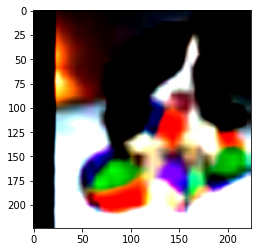

In [4]:
import numpy as np
import matplotlib.pyplot as plt
dataset_show = create_dataset()
iterator_show= dataset_show.create_dict_iterator()
images = iterator_show.get_next()["image"].asnumpy()
# Images[0].shape is (3,224,224).We need transpose as (224,224,3) for using in plt.show().
picture_show = np.transpose(images[0],(1,2,0))
plt.imshow(picture_show)


## 定义卷积神经网络

卷积神经网络已经是图像分类任务的标准算法了。卷积神经网络采用分层的结构对图片进行特征提取，由一系列的网络层堆叠而成，比如卷积层、池化层、激活层等等。
ResNet-50通常是较好的选择。首先，它足够深，常见的有34层，50层，101层。通常层次越深，表征能力越强，分类准确率越高。其次，可学习，采用了残差结构，通过shortcut连接把低层直接跟高层相连，解决了反向传播过程中因为网络太深造成的梯度消失问题。此外，ResNet-50网络的性能很好，既表现为识别的准确率，也包括它本身模型的大小和参数量。

在构建ResNet-50网络中，初始化参数，通过判断`args`的参数，用户决定用哪些功能。
可以通过改变`epoch_size`来调节模型，获得更好的性能。

In [5]:
from mindspore.communication.management import init
from mindspore.train.model import Model
from mindspore.context import ParallelMode
from resnet import resnet50
from mindspore.parallel._auto_parallel_context import auto_parallel_context

# In this way by judging the mark of args, users will decide which function to use
if not args_opt.do_eval and args_opt.run_distribute:
    context.set_auto_parallel_context(device_num=args_opt.device_num, parallel_mode=ParallelMode.DATA_PARALLEL)
    auto_parallel_context().set_all_reduce_fusion_split_indices([140])
    init()
epoch_size = args_opt.epoch_size
net = resnet50(args_opt.batch_size, args_opt.num_classes)

## 定义损失函数和优化器

接下来需要定义损失函数（Loss）和优化器（Optimizer）。损失函数是深度学习的训练目标，也叫目标函数，可以理解为神经网络的输出（Logits）和标签(Labels)之间的距离，是一个标量数据。
常见的损失函数包括均方误差、L2损失、Hinge损失、交叉熵等等。图像分类应用通常采用交叉熵损失（CrossEntropy）。
优化器用于神经网络求解（训练）。由于神经网络参数规模庞大，无法直接求解，因而深度学习中采用随机梯度下降算法（SGD）及其改进算法进行求解。MindSpore封装了常见的优化器，如SGD、ADAM、Momemtum等等。本例采用Momentum优化器，通常需要设定两个参数，动量（moment）和权重衰减项（weight decay）。

通过调用MindSpore中的API：`Momentum`和`SoftmaxCrossEntropyWithLogits`，设置损失函数和优化器的参数。

In [6]:
from mindspore.nn.optim.momentum import Momentum
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

## 调用Model高阶API进行训练和保存模型文件

完成数据预处理、网络定义、损失函数和优化器定义之后，就可以进行模型训练了。模型训练包含两层迭代，数据集的多轮迭代（epoch）和一轮数据集内按分组（batch）大小进行的单步迭代。其中，单步迭代指的是按分组从数据集中抽取数据，输入到网络中计算得到损失函数，然后通过优化器计算和更新训练参数的梯度。

为了简化训练过程，MindSpore封装了Model高阶接口。用户输入网络、损失函数和优化器完成Model的初始化，然后调用`train`接口进行训练，`train`接口参数包括迭代次数`epoch`和数据集`dataset`。

模型保存是对训练参数进行持久化的过程。`Model`类中通过回调函数的方式进行模型保存，如下面代码所示。用户通过`CheckpointConfig`设置回调函数的参数，其中，`save_checkpoint_steps`指每经过固定的单步迭代次数保存一次模型，`keep_checkpoint_max`指最多保存的模型个数。

本次体验选择`epoch_size`为10，一共迭代了十次，得到如下的运行结果。体验者可以自行设置不同的`epoch_size`，生成不同的模型，在下面的验证部分查看模型精确度。

In [7]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})

# As for train, users could use model.train
if args_opt.do_train:
    dataset = create_dataset(epoch_size)
    batch_num = dataset.get_dataset_size()
    config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
    ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory="./", config=config_ck)
    loss_cb = LossMonitor()
    model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])

[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:19.338.911 [mindspore/train/serialization.py:320] Execute save the graph process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:26.722.576 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:26.857.220 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:26.901.030 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:26.905.358 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:00:27.502.16 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 1 step: 1875, loss is 1.2926
Epoch time: 105040.679, per step time: 56.022, avg loss: 1.293
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:01:25.345.641 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:01:25.410.278 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:01:25.453.675 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:01:25.457.693 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:01:25.650.828 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 2 step: 1875, loss is 0.8226
Epoch time: 58600.447, per step time: 31.254, avg loss: 0.823
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:02:23.950.189 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:02:24.153.21 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:02:24.591.32 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:02:24.632.58 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:02:24.255.873 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 3 step: 1875, loss is 0.6473
Epoch time: 58604.997, per step time: 31.256, avg loss: 0.647
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:03:22.548.058 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:03:22.613.155 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:03:22.664.126 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:03:22.668.172 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:03:22.858.740 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 4 step: 1875, loss is 0.3235
Epoch time: 58602.803, per step time: 31.255, avg loss: 0.324
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:04:21.151.561 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:04:21.215.250 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:04:21.257.986 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:04:21.261.961 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:04:21.453.475 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 5 step: 1875, loss is 0.4524
Epoch time: 58594.759, per step time: 31.251, avg loss: 0.452
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:05:19.749.137 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:05:19.813.864 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:05:19.857.466 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:05:19.861.498 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:05:20.542.51 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 6 step: 1875, loss is 0.5436
Epoch time: 58600.685, per step time: 31.254, avg loss: 0.544
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:06:18.348.434 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:06:18.412.409 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:06:18.455.244 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:06:18.459.279 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:06:18.653.804 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 7 step: 1875, loss is 0.3080
Epoch time: 58599.470, per step time: 31.253, avg loss: 0.308
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:07:16.948.524 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:07:17.128.67 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:07:17.584.99 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:07:17.625.36 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:07:17.254.278 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 8 step: 1875, loss is 0.4420
Epoch time: 58600.389, per step time: 31.254, avg loss: 0.442
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:08:15.546.176 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:08:15.611.947 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:08:15.655.998 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:08:15.660.156 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:08:15.853.579 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 9 step: 1875, loss is 0.2113
Epoch time: 58599.249, per step time: 31.253, avg loss: 0.211
************************************************************


[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:09:14.147.518 [mindspore/train/callback/_callback.py:52] update parameters in the net.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:09:14.211.164 [mindspore/train/serialization.py:262] Execute load parameter into net process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:09:14.257.088 [mindspore/train/serialization.py:284] Load parameter into net finish, 0 parameters has not been loaded.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:09:14.261.142 [mindspore/train/serialization.py:138] Execute save checkpoint process.
[INFO] ME(27502:140200539502400,MainProcess):2020-07-18-00:09:14.437.118 [mindspore/train/serialization.py:164] Save checkpoint process finish.


epoch: 10 step: 1875, loss is 0.3720
Epoch time: 58583.483, per step time: 31.245, avg loss: 0.372
************************************************************


## 加载保存的模型进行验证

使用保存的模型，调用`model.eval`得到最终精度数据约为0.84远高于0.5，准确度较高，验证得出模型是性能较优的。

In [8]:
# As for evaluation, users could use model.eval
if args_opt.do_eval:
    if args_opt.checkpoint_path:
        param_dict = load_checkpoint(args_opt.checkpoint_path)
        load_param_into_net(net, param_dict)
    eval_dataset = create_dataset(1, training=False)
    res = model.eval(eval_dataset)
    print("result: ", res)

result:  {'acc': 0.8386833333333333}


## 总结

本次体验，带领体验者了解了MindSpore的卷积神经网络ResNet-50，通过构建ResNet-50对CIFAR-10进行分类。可以看出MindSpore的ResNet-50的构建非常容易，损失函数和优化器都有封装好的API，对于初学者和研发人员都非常的友善。